In [1]:
import os
import seaborn as sns
import numpy as np
os.chdir( f"../")
from pyMethTools.pyMethObj import *
np.random.seed(15)

### Simulate new samples

Make some fake data to base simulations off - 15 cpgs in 3 target regions for 15 samples

In [2]:
sample_size=15
n_cpg=15
meth_levels=[0.5,0.06,0.06,0.06,0.5,0.9,0.1,0.1,0.1,0.8, 0.6,0.12,0.13,0.14,0.5]
coverage = np.empty(shape=(n_cpg,sample_size), dtype=int)
meth = np.empty(shape=(n_cpg,sample_size), dtype=int)
for sample in range(0, sample_size):
    n=int(np.random.normal(30,1))
    coverage[:,sample]=np.repeat(n,n_cpg)
    for cpg,k in zip(range(0, n_cpg+1),meth_levels):
        meth[cpg,sample]=np.random.binomial(n, k, 1)[0]
regions = np.repeat([1,2,3], 5)
meth

array([[10, 10, 15, 15, 15, 14, 19, 14, 14, 17, 17, 15, 14, 12, 12],
       [ 1,  0,  2,  5,  2,  1,  1,  2,  1,  0,  1,  2,  4,  2,  4],
       [ 1,  1,  1,  1,  3,  2,  0,  2,  3,  1,  1,  1,  3,  1,  0],
       [ 2,  7,  1,  1,  2,  3,  3,  4,  2,  2,  2,  1,  2,  3,  2],
       [13, 14, 13, 17, 19, 14, 15, 11, 16, 14, 13, 13, 13, 14, 18],
       [27, 26, 26, 29, 29, 27, 23, 27, 28, 25, 29, 25, 26, 24, 25],
       [ 1,  3,  1,  4,  1,  3,  3,  2,  4,  4,  2,  6,  0,  1,  3],
       [ 2,  3,  1,  4,  0,  5,  5,  2,  2,  4,  6,  2,  5,  2,  2],
       [ 5,  6,  1,  3,  6,  2,  3,  3,  3,  1,  4,  1,  2,  2,  4],
       [25, 27, 21, 26, 24, 29, 26, 17, 24, 19, 24, 25, 22, 26, 22],
       [16, 18, 22, 24, 21, 22, 16, 16, 21, 14, 15, 18, 18, 15, 20],
       [ 5,  2,  3,  3,  4,  3,  4,  4,  2,  1,  1,  3,  6,  3,  2],
       [ 5,  4,  2,  2,  7,  4,  0,  1,  5,  3,  5,  2,  4,  0,  3],
       [ 3,  3,  1,  5,  7,  4,  5,  3,  4,  1,  8,  5,  4,  5,  6],
       [12, 15, 15, 15, 12, 18, 11

### Load the data

In [3]:
obj = pyMethObj(meth,coverage,regions)

### Fit the betabinomial models

In [4]:
obj.fit_betabinom()

### Find codistributed regions
These are stored in obj.codistrib_regions, there's a value for each cpg, with either cpg number (if not in a codistributed region) 
or the name of the codistributed region a cpg belongs to

In [5]:
obj.bbseq()
obj.codistrib_regions

array(['0', '1_1-3', '1_1-3', '1_1-3', '4', '5', '2_1-3', '2_1-3',
       '2_1-3', '9', '10', '3_1-3', '3_1-3', '3_1-3', '14'], dtype='<U21')

### Plot codistributed regions

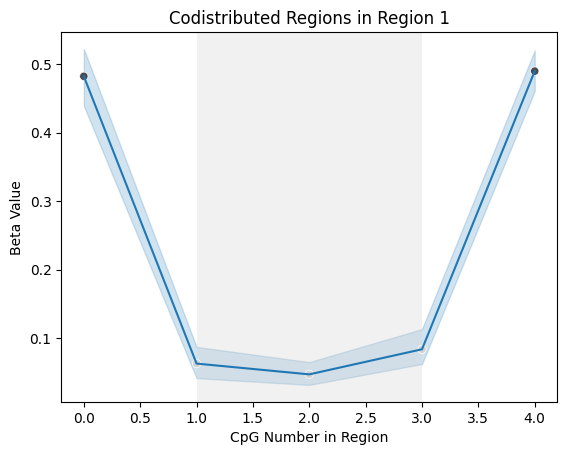

In [6]:
obj.region_plot(1) 

We can see in this simple example we found that the middle three cpgs in each region share similar methylation profiles, but do not with the first and fifth cpg

### Simulating a pertubation
We can also simulate a pertubation to a set of samples, which alters the level of methylation in some of these regions.
This is done by setting adjust factor, which specifies the log2FoldChange of the proportion of reads methylated at a CpG. This adjust factor will be applied to cpgs in n_diff_regions (here 2), with half of the regions experiencing a negative change and half a positive change in the number of reads methylated over their CpGs by default (change the prop_pos paramter to alter this).

In [7]:
sim_meth,sim_coverage,adjust=obj.sim_multiple_cpgs(sample_size=15,use_codistrib_regions=True,ncpu=1,adjust_factor=0.075,n_diff_regions=2)
combined_meth=np.concatenate([meth,sim_meth],axis=1)
combined_coverage=np.concatenate([coverage,sim_coverage],axis=1)
beta_vals=combined_meth/combined_coverage

We can see fron the adjust array that cpgs in the codsitributed region in region 2 were increased in methylation, and cpgs in the codsitributed region in region 3 were decreased, which we can also see by plotting out these regions

In [8]:
adjust

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.075,  0.075,
        0.075,  0.   ,  0.   , -0.075, -0.075, -0.075,  0.   ])

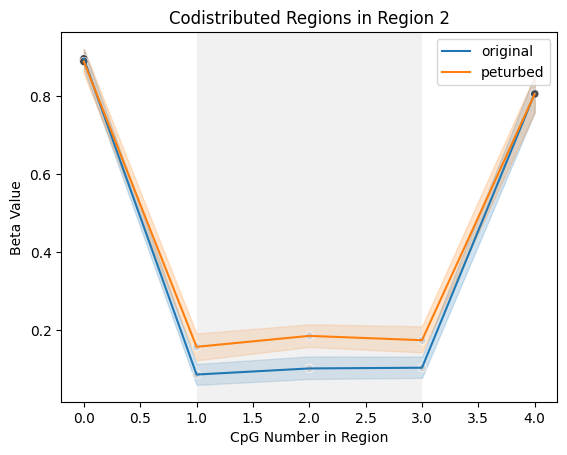

In [9]:
obj.region_plot(2, beta_vals=beta_vals,contrast=np.repeat(["original","peturbed"],15))

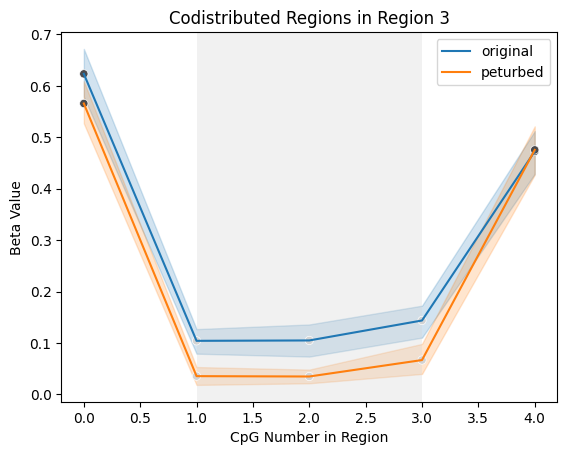

In [10]:
obj.region_plot(3, beta_vals=beta_vals,contrast=np.repeat(["original","peturbed"],15))

### Differential Methylation Analysis
Let's see if we can pick up these pertubations using beta binomial regression

Make a design matrix for proportion of reads methylated (X) and the dispersion of methylation (X_star).
We will include the intercept in both, and with an additional column specifying whether the samples were perterbed in X.

In [11]:
X=np.vstack([np.repeat(1,30),np.repeat([0,1],15)]).T
X=pd.DataFrame(X)
X.columns=['intercept','group']
X_star = X.drop(columns='group')

Load data, fit the models, and conduct the analysis while finding codistributed and differentially methylated regions, all in 3 lines of code

In [12]:
obj = pyMethObj(combined_meth,combined_coverage,regions,X,X_star)
obj.fit_betabinom()
obj.bbseq()

Lets look at the cpg level - We can see all differentially methylated cpgs are picked up 

In [13]:
obj.get_contrast(contrast="group")

,Estimate,se,t,p,padj,sig
group,0.025244,0.135854,0.185816,0.853978,0.943414,False
group,0.039604,0.276308,0.143332,0.887092,0.943414,False
group,-0.182436,0.333552,-0.546950,0.588905,0.943414,False
group,-0.151577,0.253537,-0.597849,0.554922,0.943414,False
group,0.026589,0.135804,0.195789,0.846241,0.943414,False
group,-0.073231,0.218406,-0.335297,0.739993,0.943414,False
group,0.686180,0.216266,3.172856,0.003745,0.011236,True
group,0.695625,0.200198,3.474684,0.001743,0.008716,True
group,0.592497,0.200998,2.947775,0.006528,0.016320,True
group,-0.015963,0.222812,-0.071643,0.943414,0.943414,False


Alternatively we can assess the differential methylation of codistributed regions (which were refound on this new data, 
accounting for all covariates in our design (just 'group' and intercept here).
We can see that all three codistributed and the two differentially methylated regions were found.

In [14]:
obj.get_contrast("region",contrast="group")

,Estimate,se,t,p,site,region,range,padj,sig
group,-0.092589,0.162544,-0.569622,0.573643,1_1-3,1,"(1, 2, 3)",0.573643,False
group,0.656898,0.118340,5.550927,0.000007,2_1-3,2,"(1, 2, 3)",0.000010,True
group,-1.027412,0.166625,-6.166027,0.000001,3_1-3,3,"(1, 2, 3)",0.000004,True


#### We can even simulate new data, including the effects of the covariate (group) we modelled.
We can see the effect of 'group' on the dmr in region 2 is preserved in the simulated data

In [15]:
X_sim=np.vstack([np.repeat(1,30),np.repeat([0,1],15)]).T
X_sim=pd.DataFrame(X_sim)
X_sim.columns=['intercept','group']
X_star_sim = X_sim.drop(columns='group')
sim_meth,sim_coverage,adjust=obj.sim_multiple_cpgs(X_sim,X_star_sim,sample_size=30,use_codistrib_regions=True,ncpu=1,adjust_factor=0,n_diff_regions=2)

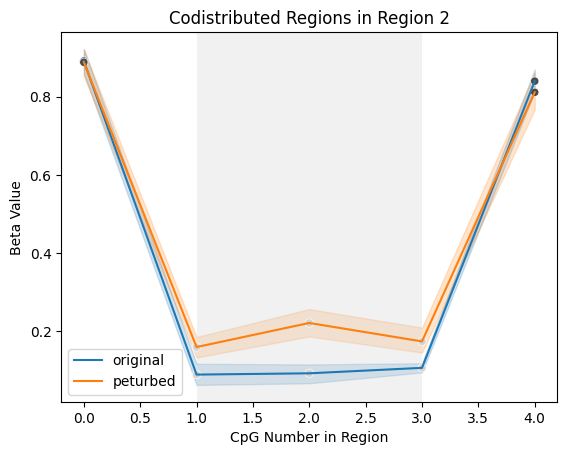

In [16]:
beta_vals_sim = sim_meth/sim_coverage
obj.region_plot(2, beta_vals=beta_vals_sim,contrast=np.repeat(["original","peturbed"],15))